# 빙산 분류 3편

앞서 빙산 분류 1편과 2편에서는 다음과 같은 한계점이 있다.

1. 머신러닝 과정에서 band_1과 band_2의 5625개의 사진에 대한 데이터를
   한 개의 값으로 대체하여 분석을 진행한 점

2. band_1과 band_2의 각각의 고유값을 추출한 뒤, 대응표본 T-검정을
   실시하였을 때, 귀무가설(빙산으로 분류된 band_1, band_2의 각각의 고유값과 
   빙산으로 분류되지 않은 band_1, band_2의 각각의 고유값이 통계적으로
   유의미한 차이가 없다.)가 채택이 되었음에도 불구하고 분석을 진행하였다는 점

3. 3d plot으로 보았을 때, 빙산으로 분류된 band_1, band_2의 고유값과 
   빙산으로 분류되지 않은 band_1, band_2의 고유값이 겹치는 부분이 있는데,
   겹치는 고유값에 대한 ing_angle에서 빙산으로 분류된 데이터와 그렇지 않은
   데이터가 유의미한 차이가 있었는지 등등 추가적인 분석이 없었다는 점

4. 딥러닝 적용시에 train_data와 test_data의 개수가 test_data가
   더 많았는데도 불구하고 데이터 증식 등의 방법을 고려하지 않았다는 점

- train데이터가 test데이터에 비해 적기 때문에, 딥러닝의 전이학습(가중치의 일부를
    능력이 유사하거나 새로운 분야의 신경망에 복사한 후, 그 상태로 재학습을 수행하는 것)      을 고려할 수도 있었는데, 하지 않았다는 점

- 위의 경우도 딥러닝의 전이학습의 경우 모델이 빙산 유무를 분류는 잘하지만,
    빙산을 분류하는 방법을 스스로 터득하는 데 있어서 한계가 존재하는데, 이를 보완할 수      있는 강화학습 방법을 생각해보지 못 했다는 점

5.  VGG16, VGG19 모형을 그대로 적용하지 못했다는 점

6. image의 RGB값에 대한 정보가 모델에 적용되지 않았다는 점

7. 모델의 마지막 부분에 fully connected + ReLU가 반영되지 않았다는 점
   flatten이후에 각 층의 뉴런과 fully connected가 되지 않음.

- 참고자료: https://bskyvision.com/504

8. 딥러닝에 더 다양한 모델들이 종류하는데, 이를 적용해보지 않았다는 점

따라서, 이러한 분석의 한계를 극복하기 위해 빙산분류에 대해 추가적인 분석을 진행하도록 한다.

# 데이터 불러오기

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/statoil-iceberg-classifier-challenge.zip"

In [ ]:
!pip install py7zr

In [ ]:
import os 
import py7zr
import pandas as pd

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with py7zr.SevenZipFile("/content/train.json.7z", 'r') as archive:
    archive.extractall(path="/content/train")

with py7zr.SevenZipFile("/content/test.json.7z", 'r') as archive:
    archive.extractall(path="/content/test")

for dirname, _, filenames in os.walk('/content'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [ ]:
train=pd.read_json("/content/train/data/processed/train.json")
test=pd.read_json("/content/test/data/processed/test.json")

In [ ]:
with py7zr.SevenZipFile("/content/sample_submission.csv.7z", 'r') as archive:
    archive.extractall(path="/content/sample_submission")

for dirname, _, filenames in os.walk('/content'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [ ]:
sample_submission=pd.read_csv("/content/sample_submission/data/processed/sample_submission.csv")

#EDA

결측치 확인

In [ ]:
train.loc[train['inc_angle']=='na']

,id,band_1,band_2,inc_angle,is_iceberg
101,f9209504,"[-13.271194, -12.898959, -14.867657, -16.54327...","[-22.941357, -23.540695, -24.41008, -24.879778...",na,0
126,551856d8,"[-22.102318, -23.761854, -26.414414999999998, ...","[-26.414314, -30.252075, -26.730301, -27.39882...",na,0
142,89842932,"[-13.514271, -11.831821, -13.580964999999999, ...","[-27.900896, -26.317339, -23.394848, -24.97853...",na,0
145,f76458ab,"[-17.553728, -17.245392, -17.553867, -16.85065...","[-25.305712, -24.114067, -25.832432, -25.05414...",na,0
176,9847a428,"[-21.199528, -20.517969, -19.016716, -18.10160...","[-21.024048, -20.852085, -22.962326, -25.46114...",na,0
...,...,...,...,...,...
1599,04e11240,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",na,0
1600,c7d6f6f8,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",na,0
1601,bba1a0f1,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",na,0
1602,7f66bb44,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",na,0


고유값 추출

In [ ]:
train_eigen=train.copy()

In [ ]:
train_eigen['e_band_1']=0
train_eigen['e_band_2']=0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [ ]:
for i in range(0,1604):
    v=train_eigen[['band_1','band_2']]
    v1=pd.Series(v.iloc[i, 0])
    v2=pd.Series(v.iloc[i, 1])
    v3=pd.concat([v1,v2], axis=1)
    v_cen=v3-v3.mean(axis=0)
    v_cov=np.dot(v_cen.T, v_cen)
    w, v=np.linalg.eig(v_cov)
    train_eigen['e_band_1'][i]=w[0]
    train_eigen['e_band_2'][i]=w[1]
    i+=1

In [ ]:
train_eigen.columns

Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg', 'e_band_1',
       'e_band_2'],
      dtype='object')

In [ ]:
for i in range(0,1604):
    if train_eigen.iloc[i, 3]=='na':
        train_eigen.iloc[i, 3]=0

In [ ]:
train_eigen['inc_angle']=train_eigen['inc_angle'].astype(float)

In [ ]:
import random
def random_color():
  color_map = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r',
               'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r',
               'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r',
               'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r',
               'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r',
               'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r',
               'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r',
               'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r',
               'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',
               'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma']
  color = random.choice(color_map)
  print(color)
  return color

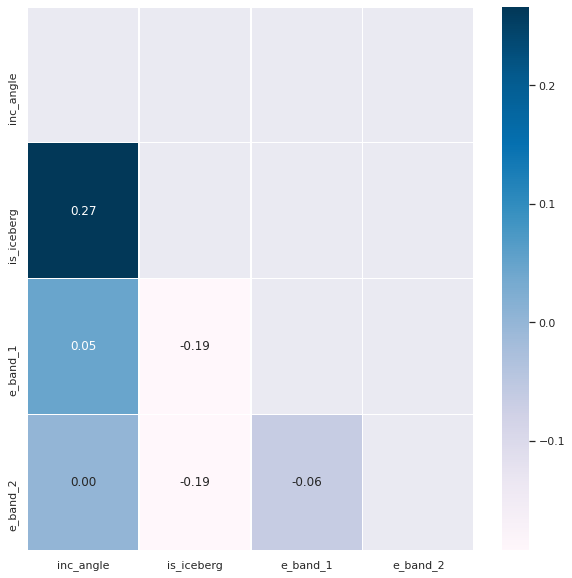

In [ ]:
plt.figure(figsize=(10,10))
mask = np.zeros_like(train_eigen.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=train_eigen.corr(), mask=mask, annot=True, fmt ='.2f', linewidths=.5, cmap='PuBu')
plt.show()

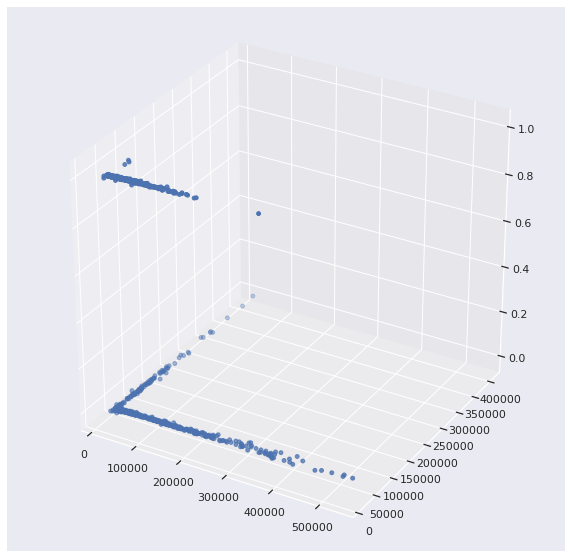

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

p_band_1_mean=np.array(train_eigen['e_band_1'])
p_band_2_mean=np.array(train_eigen['e_band_2'])
p_is_iceberg=np.array(train_eigen['is_iceberg'])

xs=p_band_1_mean
ys=p_band_2_mean
zs=p_is_iceberg

sns.set(style="darkgrid")

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(xs,ys,zs, marker='o', s=15, cmap=plt.cm.rainbow)

In [ ]:
ship_eigen=train_eigen.loc[train_eigen['is_iceberg']==0]
iceberg_eigen=train_eigen.loc[train_eigen['is_iceberg']==1]

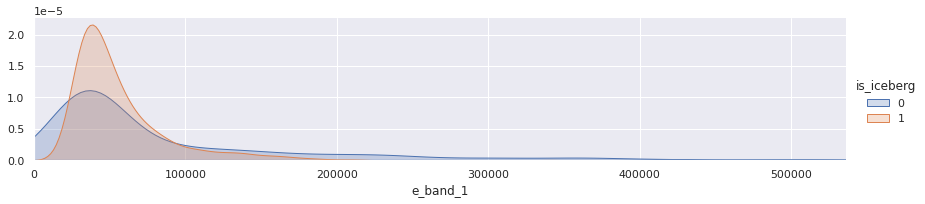

In [ ]:
facet = sns.FacetGrid(train_eigen, hue ='is_iceberg', aspect=4)
facet.map(sns.kdeplot,'e_band_1',shade = True) # kde : 이차원 밀집도 그래프
facet.set(xlim=(0,train_eigen['e_band_1'].max()))
facet.add_legend()
sns.axes_style('dark')

plt.show()

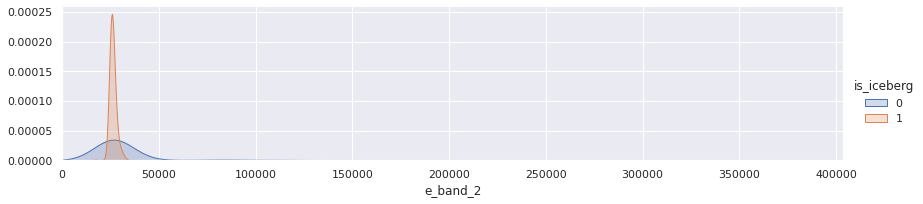

In [ ]:
facet = sns.FacetGrid(train_eigen, hue ='is_iceberg', aspect=4)
facet.map(sns.kdeplot,'e_band_2',shade = True) # kde : 이차원 밀집도 그래프
facet.set(xlim=(0,train_eigen['e_band_2'].max()))
facet.add_legend()
sns.axes_style('dark')

plt.show()

In [ ]:
ship_a=ship_eigen.loc[ship_eigen['e_band_1']<100000]
ship_b=ship_a.loc[ship_a['e_band_2']>20000]
ship_b=ship_b.loc[ship_b['e_band_2']<30000]

In [ ]:
ship_b=ship_b.reset_index()

In [ ]:
ship_b.drop('index', axis=1, inplace=True)

In [ ]:
iceberg_a=iceberg_eigen.loc[iceberg_eigen['e_band_1']<100000]
iceberg_b=iceberg_a.loc[iceberg_a['e_band_2']>20000]
iceberg_b=iceberg_b.loc[iceberg_b['e_band_2']<30000]

In [ ]:
iceberg_b=iceberg_b.reset_index()
iceberg_b.drop('index', axis=1, inplace=True)

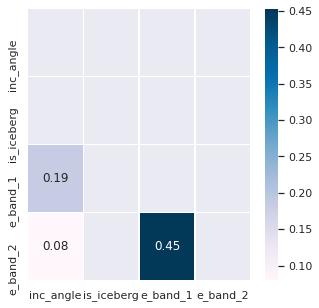

In [ ]:
plt.figure(figsize=(5,5))
mask = np.zeros_like(ship_b.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=ship_b.corr(), mask=mask, annot=True, fmt ='.2f', linewidths=.5, cmap='PuBu')
plt.show()

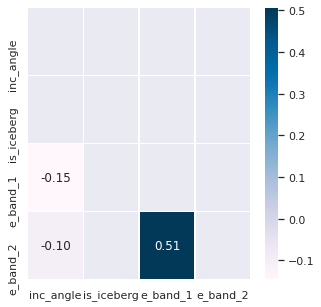

In [ ]:
plt.figure(figsize=(5,5))
mask = np.zeros_like(iceberg_b.corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=iceberg_b.corr(), mask=mask, annot=True, fmt ='.2f', linewidths=.5, cmap='PuBu')
plt.show()

- 배로 분류가 된 경우에는 band_1,band_2의 고유값이 빙산과 겹치는 부분에 있어서, inc_angle과 양의 상관관계를 가지나, 빙산으로 분류된 경우에는 inc_angle과 음의 상관관계를 가진다.




In [ ]:
print(len(ship_b.index))
print(len(iceberg_b.index))

526
663


In [ ]:
random.randrange(0,526)

183

In [ ]:
i=267

배로 분류된 band_1, band_2 사진

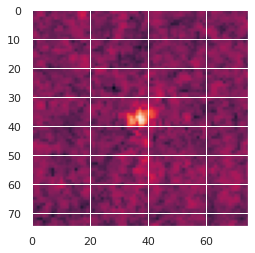

In [ ]:
plt.imshow(np.array(ship_b.iloc[i, 1]).astype(np.float32).reshape(75,75))
plt.show()

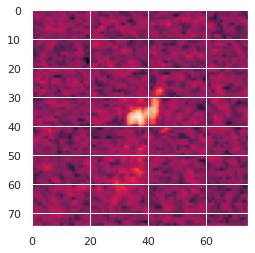

In [ ]:
plt.imshow(np.array(ship_b.iloc[i, 2]).astype(np.float32).reshape(75,75))
plt.show()

빙산으로 분류된 band_1, band_2 사진

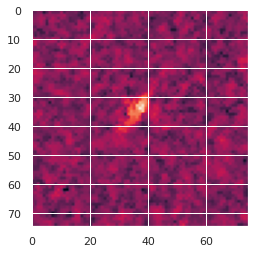

In [ ]:
plt.imshow(np.array(iceberg_b.iloc[i, 1]).astype(np.float32).reshape(75,75))
plt.show()

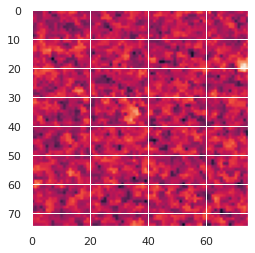

In [ ]:
plt.imshow(np.array(iceberg_b.iloc[i, 2]).astype(np.float32).reshape(75,75))
plt.show()

육안으로 구별하기 매우 어렵다.

#딥러닝 모델 적용

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from keras import optimizers
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

In [ ]:
for i in range(0,1604):
    if train.iloc[i, 3]=='na':
        train.iloc[i, 3]=0

In [ ]:
train['inc_angle']=train['inc_angle'].astype('float')
train['id']=le.fit_transform(train['id'])
test['id']=le.fit_transform(test['id'])

In [ ]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#np.concatenate해서 새로운 채널을 하나더 만들어주는 것이다 컬러이미지이기 때문에 
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [ ]:
Y_train=train['is_iceberg']

In [ ]:
Y_train=np.array(Y_train)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1604, 75, 75, 3)
(8424, 75, 75, 3)


In [ ]:
seed=0
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)

In [ ]:
y_train=y_train.reshape(-1,1)
y_val=y_val.reshape(-1,1)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(X_test.shape)

(1443, 75, 75, 3)
(1443, 1)
(161, 75, 75, 3)
(161, 1)
(8424, 75, 75, 3)


빙산분류 2편에서 가장 좋았던 모델을 K겹 교차검증(Stratified KFold)를 적용해보겠습니다.

K겹 교차검증(StratifiedKFold)
--

In [ ]:
MODEL_DIR='./model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer=ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10)

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_fold=10
skf=StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:
accuracy=[]

for train, test in skf.split(X_train,Y_train):
    model = Sequential()
    model.add(Conv2D(input_shape=(75,75,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(BatchNormalization())
    #####
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    ####
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    ####
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    ####
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.6))
    model.add(Flatten())
    
    model.add(Dense(units=512,activation="relu"))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    
    opt=SGD(lr=0.001, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
    model.fit(X_train[train], Y_train[train], batch_size=10, epochs=300)
    k_accuracy="%.4f"%(model.evaluate(X_train[test], Y_train[test])[1])
    accuracy.append(k_accuracy)

In [ ]:
print("\n %.f fold accuracy:"%n_fold, accuracy)


 10 fold accuracy: ['0.9006', '0.9379', '0.9255', '0.8571', '0.9125', '0.8813', '0.9625', '0.9000', '0.8875', '0.8625']


In [ ]:
model.save('vgg19_apply_StratifiedKFold.h5')

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
y_pred_1=pd.DataFrame(y_pred, columns=['is_iceberg'])
sample_submission_1=sample_submission.drop(['is_iceberg'], axis=1)
submission=pd.concat([sample_submission_1, y_pred_1], axis=1)

In [ ]:
submission.to_csv('submission_10.csv', index=False)

- 결과가 더 안 좋아졌음

# 딥러닝 모델 고급 심화과정


데이터 이미저 변환
--

In [ ]:
import os,shutil

In [ ]:
ship_dir = '/content/ship'
iceberg_dir = '/content/iceberg'

In [ ]:
os.mkdir(ship_dir) 
os.mkdir(iceberg_dir)

In [ ]:
band_1=np.array([np.array(i).reshape(75,75) for i in train['band_1']])
band_2=np.array([np.array(i).reshape(75,75) for i in train['band_2']])

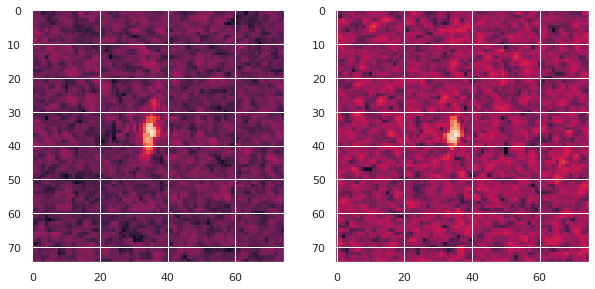

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(band_1[0])
ax[1].imshow(band_2[0])

In [ ]:
if train.is_iceberg[0]==0:
    print("위 사진은 배 사진입니다.")

위 사진은 배 사진입니다.


In [ ]:
ship=train.loc[train['is_iceberg']==0]
iceberg=train.loc[train['is_iceberg']==1]

이미지 만들기
--

출처: https://www.kaggle.com/oscarsommervold/iceberg-challenge-exploration

In [ ]:
def createIm(data):
    imgs = []

    for i, row in data.iterrows():
    #make 75x75 image
        b_1 = np.array(row['band_1']).reshape(75, 75)
        b_2 = np.array(row['band_2']).reshape(75, 75)
        b_3 = b_1 + b_2

        r = (b_1 + abs(b_1.min())) / np.max((b_1 + abs(b_1.min())))
        g = (b_2 + abs(b_2.min())) / np.max((b_2 + abs(b_2.min())))
        b = (b_3 + abs(b_3.min())) / np.max((b_3 + abs(b_3.min())))

        imgs.append(np.dstack((r, g, b)))
    return np.array(imgs)

배, 빙산 이미지 학습용과 검증용으로 나눠서 저장하기

In [ ]:
#ship_img=createIm(ship)

In [ ]:
#iceberg_img=createIm(iceberg)

In [ ]:
#ship_img.shape

In [ ]:
#for i,x in enumerate(ship_img):
#    plt.imsave('/content/ship/ship_%d.png'%i,x)
#
#for i,x in enumerate(iceberg_img):
#    plt.imsave('/content/iceberg/iceberg_%d.png'%i,x)

In [ ]:
#print('배 이미지 전체 개수', len(os.listdir(ship_dir)))
#print('빙산 이미지 전체 개수', len(os.listdir(iceberg_dir)))

In [ ]:
from sklearn.model_selection import train_test_split

ship_train, ship_validation=train_test_split(ship, test_size=0.2, random_state=42)

In [ ]:
print("ship 개수", len(ship.index))
print("ship_train 개수", len(ship_train.index))
print("ship_validation 개수", len(ship_validation.index))

ship 개수 851
ship_train 개수 680
ship_validation 개수 171


In [ ]:
iceberg_train, iceberg_validation=train_test_split(iceberg, test_size=0.2, random_state=42)

In [ ]:
print("iceberg 개수", len(iceberg.index))
print("iceberg_train 개수", len(iceberg_train.index))
print("iceberg_validation 개수", len(iceberg_validation.index))

iceberg 개수 753
iceberg_train 개수 602
iceberg_validation 개수 151


In [ ]:
ship_train_dir = '/content/ship_train'
ship_validation_dir='/content/ship_validation'
iceberg_train_dir = '/content/iceberg_train'
iceberg_validation_dir='/content/iceberg_validation'

In [ ]:
os.mkdir(ship_train_dir) 
os.mkdir(ship_validation_dir)
os.mkdir(iceberg_train_dir)
os.mkdir(iceberg_validation_dir)

In [ ]:
ship_train_img=createIm(ship_train)
ship_validation_img=createIm(ship_validation)

In [ ]:
print("배 학습용 이미지 shape:", ship_train_img.shape)
print("배 검증용 이미지 shape:", ship_validation_img.shape)

배 학습용 이미지 shape: (680, 75, 75, 3)
배 검증용 이미지 shape: (171, 75, 75, 3)


In [ ]:
for i,x in enumerate(ship_train_img):
    plt.imsave('/content/ship_train/ship_train_%d.png'%i,x)

for i,x in enumerate(ship_validation_img):
    plt.imsave('/content/ship_validation/ship_validaion_%d.png'%i,x)

In [ ]:
iceberg_train_img=createIm(iceberg_train)
iceberg_validation_img=createIm(iceberg_validation)

In [ ]:
print("빙산 학습용 이미지 shape:", iceberg_train_img.shape)
print("빙산 검증용 이미지 shape:", iceberg_validation_img.shape)

빙산 학습용 이미지 shape: (602, 75, 75, 3)
빙산 검증용 이미지 shape: (151, 75, 75, 3)


In [ ]:
for i,x in enumerate(iceberg_train_img):
    plt.imsave('/content/iceberg_train/iceberg_train_%d.png'%i,x)

for i,x in enumerate(iceberg_validation_img):
    plt.imsave('/content/iceberg_validation/iceberg_validaion_%d.png'%i,x)

테스트 이미지 데이터 저장하기

In [ ]:
test_dir = '/content/test_img'

In [ ]:
os.mkdir(test_dir) 

In [ ]:
test_img=createIm(test)

In [ ]:
print("테스트용 이미지 shape:", test_img.shape)

테스트용 이미지 shape: (8424, 75, 75, 3)


In [ ]:
for i,x in enumerate(test_img):
    plt.imsave('/content/test_img/test_%d.png'%i,x)

In [ ]:
print('테스트 이미지 전체 개수', len(os.listdir(test_dir)))

테스트 이미지 전체 개수 8424


학습용 이미지 저장하기

In [ ]:
train_dir = '/content/train_img'

In [ ]:
os.mkdir(train_dir) 

In [ ]:
train_img=createIm(train)

In [ ]:
print("학습용 이미지 shape:", train_img.shape)

학습용 이미지 shape: (1604, 75, 75, 3)


In [ ]:
for i,x in enumerate(train_img):
    plt.imsave('/content/train_img/train_%d.png'%i,x)

In [ ]:
print('학습 이미지 전체 개수', len(os.listdir(train_dir)))

학습 이미지 전체 개수 1604


학습용 이미지를 학습분리용과 검증용 이미지로 나눠서 저장하기

In [ ]:
train_tn, validation=train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
train_tn_dir = '/content/train_tn_img'

In [ ]:
validation_dir = '/content/validation_img'

In [ ]:
os.mkdir(validation_dir) 

In [ ]:
os.mkdir(train_tn_dir)

In [ ]:
validation_img=createIm(validation)

In [ ]:
train_tn_img=createIm(train_tn)

In [ ]:
print("검증용 이미지 shape:", validation_img.shape)

검증용 이미지 shape: (321, 75, 75, 3)


In [ ]:
print("학습분리용 이미지 shape:", train_tn_img.shape)

학습분리용 이미지 shape: (1283, 75, 75, 3)


In [ ]:
for i,x in enumerate(validation_img):
    plt.imsave('/content/validation_img/validation_%d.png'%i,x)

In [ ]:
for i,x in enumerate(train_tn_img):
    plt.imsave('/content/train_tn_img/train_tn_%d.png'%i,x)

In [ ]:
print('검증 이미지 전체 개수', len(os.listdir(validation_dir)))

검증 이미지 전체 개수 321


In [ ]:
print('학습분리용 이미지 전체 개수', len(os.listdir(train_tn_dir)))

학습분리용 이미지 전체 개수 1283


# Pytorch로 딥러닝 적용해보기


참고 자료(데이터로더 만들기):

 https://www.kaeee.de/2021/04/29/pytorch-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%A1%9C%EB%8D%94-%EB%A7%8C%EB%93%A4%EA%B8%B0.html



참고 자료(Faster-R-CNN):

 https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book/blob/master/book/chapters/object-detection/Ch5-Faster-R-CNN.ipynb



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [ ]:
if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')

print(f"Using PyTorch version: {torch.__version__,}, 'DEVICE: {DEVICE}")

Using PyTorch version: ('1.9.0+cu102',), 'DEVICE: cpu


In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [ ]:
BATCH_SIZE=10
EPOCHS=300

In [ ]:
from glob import glob

training_list=glob('/content/train_tn_img/*.png')
validation_list=glob('/content/validation_img/*.png')

In [ ]:
from skimage import io, transform

In [ ]:
train.columns

Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'], dtype='object')

In [ ]:
class Mydataset(Dataset):
    def __init__(self, data_path_list, classes, transform=None):
        self.path_list=data_path_list
        self.label=get_label(data_path_list)
        self.transform=transform
        self.classes=classes

    def get_label(data_path_list):
        label_list=[]
        for path in data_path_list:
            label_list.append(path.split('/')[-2])
        return label_list

    def __len__(self):
        return len(self.path_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx=idx.tolist()
        image=io.imread(self.path_list[idx])
        if self.transform is not None:
            image=self.transform(image)
        return image, self.classes.index(self.label[idx])

In [ ]:
from torchvision import datasets, transforms
import torch.optim as optim

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
train_loader=torch.utils.data.DataLoader(
        dataset=training_list,
        batch_size=BATCH_SIZE,
        shuffle = True
)

val_loader=torch.utils.data.DataLoader(
        dataset=validation_list,
        batch_size=BATCH_SIZE,
        shuffle = False
)

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision.datasets import ImageFolder

- Image Folder를 이용하면 데이터셋 객체로 불러올 수 있음

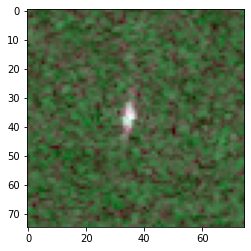

In [ ]:
img=Image.open('/content/train_img/train_0.png')
imshow(np.asarray(img))

In [ ]:
transform_train=transforms.Compose([
                                    transforms.ToTensor(),
])

In [ ]:
transform=transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize((75,75)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))
    ]
)

In [ ]:
train_dataset=ImageFolder(root='/content/train_tn_img', transform=transform_train)

FileNotFoundError: ignored

In [ ]:
print([entry.name for entry in os.scandir('/content/train_tn_img')])

['train_tn_513.png', 'train_tn_1086.png', 'train_tn_476.png', 'train_tn_1089.png', 'train_tn_1104.png', 'train_tn_937.png', 'train_tn_585.png', 'train_tn_419.png', 'train_tn_946.png', 'train_tn_79.png', 'train_tn_459.png', 'train_tn_341.png', 'train_tn_624.png', 'train_tn_953.png', 'train_tn_685.png', 'train_tn_334.png', 'train_tn_1127.png', 'train_tn_446.png', 'train_tn_587.png', 'train_tn_1061.png', 'train_tn_183.png', 'train_tn_747.png', 'train_tn_465.png', 'train_tn_265.png', 'train_tn_151.png', 'train_tn_599.png', 'train_tn_1188.png', 'train_tn_160.png', 'train_tn_529.png', 'train_tn_76.png', 'train_tn_628.png', 'train_tn_864.png', 'train_tn_528.png', 'train_tn_575.png', 'train_tn_77.png', 'train_tn_1105.png', 'train_tn_606.png', 'train_tn_440.png', 'train_tn_602.png', 'train_tn_580.png', 'train_tn_1047.png', 'train_tn_439.png', 'train_tn_798.png', 'train_tn_131.png', 'train_tn_949.png', 'train_tn_16.png', 'train_tn_214.png', 'train_tn_695.png', 'train_tn_1219.png', 'train_tn_1.pn

In [ ]:
len(os.listdir('/content/train_tn_img'))

1283

In [ ]:
type(os.listdir('/content/train_tn_img')[0])

str

In [ ]:
os.scandir('/content/train_tn_img')

In [ ]:
import torchvision.models as models
model = models.resnet18().cuda()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
EPOCHS = 3
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("[{}] Test Loss: {:.4f}, accuracy: {:.2f}%\n".format(epoch, test_loss, test_accuracy))

TypeError: ignored

In [ ]:
train_loader

# 파이토치 2

In [ ]:
transform=transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))
    ]
)

NameError: ignored

In [ ]:
train_data=train[['is_iceberg']]

In [ ]:
for i in range(0, 5625):
    train_data[["%s"%i]]=0

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Columns: 5626 entries, is_iceberg to 5624
dtypes: int64(5626)
memory usage: 68.8 MB


In [ ]:
train.tail()

,id,band_1,band_2,inc_angle,is_iceberg
1599,34,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",0.0,0
1600,1277,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",0.0,0
1601,1201,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",0.0,0
1602,813,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",0.0,0
1603,1003,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",0.0,0


In [ ]:
len(train['band_1'][0])

5625

In [ ]:
from tqdm import tqdm

In [ ]:
#for i in tqdm(range(0, 1603)):
#    for j in range(0,5625):
#        avg=(train['band_1'][i][j]+train['band_2'][i][j])/2
#        train_data.iloc[i, j+1]=avg

In [ ]:
#for j in range(0,5625):
#    avg=(train['band_1'][1603][j]+train['band_2'][1603][j])/2
#    train_data.iloc[1603, j+1]=avg

In [ ]:
train_data.head()

,is_iceberg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,5585,5586,5587,5588,5589,5590,5591,5592,5593,5594,5595,5596,5597,5598,5599,5600,5601,5602,5603,5604,5605,5606,5607,5608,5609,5610,5611,5612,5613,5614,5615,5616,5617,5618,5619,5620,5621,5622,5623,5624
0,0,-27.516239,-28.346024,-29.849607,-30.864227,-30.963351,-31.932494,-31.610689,-31.186241,-28.668869,-28.123595,-28.176069,-28.659156,-29.384707,-28.880971,-30.641927,-29.928410,-32.146938,-29.648208,-28.600894,-28.881224,-26.885544,-28.301389,-29.385128,-29.270574,-29.104200,-29.192203,-28.923078,-26.788966,-26.918658,-28.679613,-28.902377,-28.881688,-28.759386,-31.933631,-31.312197,-32.281337,-31.912928,-31.187463,-33.239269,...,-27.703466,-27.495745,-27.495745,-27.791129,-29.138157,-29.540079,-27.348178,-27.579403,-30.965544,-30.063817,-29.456882,-31.913939,-29.930306,-28.525839,-27.696137,-26.986437,-29.775353,-31.349887,-31.101691,-29.930600,-28.831892,-28.526175,-27.378001,-28.303496,-30.064449,-29.062941,-27.634154,-29.775815,-32.515404,-30.644581,-30.567753,-31.424085,-31.424127,-32.283316,-31.692144,-29.553387,-29.095856,-28.662275,-28.277068,-28.682054
1,0,-21.874348,-21.452430,-20.783020,-18.216970,-16.267262,-19.317404,-19.404407,-19.741295,-19.845403,-19.718874,-20.404165,-20.406857,-21.983487,-20.632649,-19.003701,-19.846968,-18.864982,-18.089260,-18.299746,-19.034603,-19.027947,-19.626175,-20.249744,-19.505873,-18.172304,-15.395694,-15.425338,-18.985436,-19.577364,-19.399479,-20.302589,-19.617967,-20.643479,-20.643479,-21.010314,-20.750556,-18.888305,-17.336561,-18.171489,...,-18.537278,-19.903814,-20.065073,-22.175490,-23.486013,-24.810989,-23.518339,-21.230422,-20.786289,-22.723111,-19.380461,-17.203792,-16.869612,-19.214502,-20.151777,-18.974390,-20.508624,-22.674506,-20.865127,-19.464913,-20.947913,-21.928638,-19.688966,-19.688966,-19.155498,-19.126065,-19.111453,-19.536877,-18.189591,-16.897439,-16.614865,-17.550635,-18.037753,-18.303483,-16.596457,-16.918363,-18.347651,-19.027014,-16.735104,-16.945191
2,1,-24.737316,-24.348173,-22.762496,-21.281909,-21.625550,-22.598706,-19.949909,-21.479501,-21.827160,-21.820889,-23.626188,-24.552553,-25.097745,-23.768705,-23.902383,-23.500851,-19.773654,-21.944795,-23.902534,-24.979018,-25.346283,-26.779308,-24.552968,-24.552968,-23.266340,-23.623533,-26.053951,-25.810395,-25.220653,-25.490880,-24.219578,-24.107930,-27.002448,-24.863687,-22.374485,-22.130930,-24.368296,-27.129138,-24.838552,...,-22.827363,-23.273222,-24.350057,-22.365667,-22.365667,-21.774489,-23.514710,-24.406979,-23.490039,-22.232216,-21.661870,-22.000763,-22.409039,-22.306885,-22.643794,-23.615470,-22.344744,-21.723303,-25.011329,-22.631310,-21.795887,-22.659314,-23.023135,-22.828194,-25.037903,-25.434284,-23.854048,-25.291956,-24.890822,-25.956831,-28.522677,-27.987237,-26.203260,-25.011894,-24.265597,-24.276709,-23.277443,-23.004358,-24.120728,-25.439642
3,0,-25.172014,-25.301307,-25.581637,-26.550778,-26.928707,-26.673208,-26.208858,-26.461401,-26.660945,-25.059697,-26.648675,-25.094149,-25.577239,-26.539157,-26.192504,-25.292862,-26.271044,-27.386834,-28.892249,-27.386919,-26.551500,-25.986729,-26.104883,-25.572890,-24.605756,-24.888399,-26.929642,-27.278950,-27.152491,-26.551883,-25.348015,-25.987154,-28.024162,-24.743151,-24.743195,-26.552138,-26.718175,-28.024374,-29.672519,...,-26.852196,-25.371614,-24.105069,-26.375405,-26.552734,-26.041252,-25.196191,-26.801097,-27.023905,-27.770283,-27.644435,-26.238947,-25.464981,-24.227390,-23.178567,-24.122820,-27.403353,-29.204845,-25.904590,-24.164551,-24.164593,-25.414023,-27.065025,-28.034168,-28.189640,-27.867836,-28.508868,-27.637408,-26.107052,-27.133716,-27.771177,-29.352289,-27.259736,-26.096393,-25.442506,-25.188609,-26.664050,-27.508185,-28.595381,-27.803610
4,0,-26.606935,-26.712036,-26.712036,-25.028059,-24.250765,-25.664124,-26.080205,-25.082771,-26.540468,-25.500485,-26.414711,-24.957043,-24.251300,-23.988076,-25.922797,

In [ ]:
#train_data.to_csv("train_data.csv", index=False)

In [ ]:
train_data

,is_iceberg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,5585,5586,5587,5588,5589,5590,5591,5592,5593,5594,5595,5596,5597,5598,5599,5600,5601,5602,5603,5604,5605,5606,5607,5608,5609,5610,5611,5612,5613,5614,5615,5616,5617,5618,5619,5620,5621,5622,5623,5624
0,0,-27.516239,-28.346024,-29.849607,-30.864227,-30.963351,-31.932494,-31.610689,-31.186241,-28.668869,-28.123595,-28.176069,-28.659156,-29.384707,-28.880971,-30.641927,-29.928410,-32.146938,-29.648208,-28.600894,-28.881224,-26.885544,-28.301389,-29.385128,-29.270574,-29.104200,-29.192203,-28.923078,-26.788966,-26.918658,-28.679613,-28.902377,-28.881688,-28.759386,-31.933631,-31.312197,-32.281337,-31.912928,-31.187463,-33.239269,...,-27.703466,-27.495745,-27.495745,-27.791129,-29.138157,-29.540079,-27.348178,-27.579403,-30.965544,-30.063817,-29.456882,-31.913939,-29.930306,-28.525839,-27.696137,-26.986437,-29.775353,-31.349887,-31.101691,-29.930600,-28.831892,-28.526175,-27.378001,-28.303496,-30.064449,-29.062941,-27.634154,-29.775815,-32.515404,-30.644581,-30.567753,-31.424085,-31.424127,-32.283316,-31.692144,-29.553387,-29.095856,-28.662275,-28.277068,-28.682054
1,0,-21.874348,-21.452430,-20.783020,-18.216970,-16.267262,-19.317404,-19.404407,-19.741295,-19.845403,-19.718874,-20.404165,-20.406857,-21.983487,-20.632649,-19.003701,-19.846968,-18.864982,-18.089260,-18.299746,-19.034603,-19.027947,-19.626175,-20.249744,-19.505873,-18.172304,-15.395694,-15.425338,-18.985436,-19.577364,-19.399479,-20.302589,-19.617967,-20.643479,-20.643479,-21.010314,-20.750556,-18.888305,-17.336561,-18.171489,...,-18.537278,-19.903814,-20.065073,-22.175490,-23.486013,-24.810989,-23.518339,-21.230422,-20.786289,-22.723111,-19.380461,-17.203792,-16.869612,-19.214502,-20.151777,-18.974390,-20.508624,-22.674506,-20.865127,-19.464913,-20.947913,-21.928638,-19.688966,-19.688966,-19.155498,-19.126065,-19.111453,-19.536877,-18.189591,-16.897439,-16.614865,-17.550635,-18.037753,-18.303483,-16.596457,-16.918363,-18.347651,-19.027014,-16.735104,-16.945191
2,1,-24.737316,-24.348173,-22.762496,-21.281909,-21.625550,-22.598706,-19.949909,-21.479501,-21.827160,-21.820889,-23.626188,-24.552553,-25.097745,-23.768705,-23.902383,-23.500851,-19.773654,-21.944795,-23.902534,-24.979018,-25.346283,-26.779308,-24.552968,-24.552968,-23.266340,-23.623533,-26.053951,-25.810395,-25.220653,-25.490880,-24.219578,-24.107930,-27.002448,-24.863687,-22.374485,-22.130930,-24.368296,-27.129138,-24.838552,...,-22.827363,-23.273222,-24.350057,-22.365667,-22.365667,-21.774489,-23.514710,-24.406979,-23.490039,-22.232216,-21.661870,-22.000763,-22.409039,-22.306885,-22.643794,-23.615470,-22.344744,-21.723303,-25.011329,-22.631310,-21.795887,-22.659314,-23.023135,-22.828194,-25.037903,-25.434284,-23.854048,-25.291956,-24.890822,-25.956831,-28.522677,-27.987237,-26.203260,-25.011894,-24.265597,-24.276709,-23.277443,-23.004358,-24.120728,-25.439642
3,0,-25.172014,-25.301307,-25.581637,-26.550778,-26.928707,-26.673208,-26.208858,-26.461401,-26.660945,-25.059697,-26.648675,-25.094149,-25.577239,-26.539157,-26.192504,-25.292862,-26.271044,-27.386834,-28.892249,-27.386919,-26.551500,-25.986729,-26.104883,-25.572890,-24.605756,-24.888399,-26.929642,-27.278950,-27.152491,-26.551883,-25.348015,-25.987154,-28.024162,-24.743151,-24.743195,-26.552138,-26.718175,-28.024374,-29.672519,...,-26.852196,-25.371614,-24.105069,-26.375405,-26.552734,-26.041252,-25.196191,-26.801097,-27.023905,-27.770283,-27.644435,-26.238947,-25.464981,-24.227390,-23.178567,-24.122820,-27.403353,-29.204845,-25.904590,-24.164551,-24.164593,-25.414023,-27.065025,-28.034168,-28.189640,-27.867836,-28.508868,-27.637408,-26.107052,-27.133716,-27.771177,-29.352289,-27.259736,-26.096393,-25.442506,-25.188609,-26.664050,-27.508185,-28.595381,-27.803610
4,0,-26.606935,-26.712036,-26.712036,-25.028059,-24.250765,-25.664124,-26.080205,-25.082771,-26.540468,-25.500485,-26.414711,-24.957043,-24.251300,-23.988076,-25.922797,

In [ ]:
BATCH_SIZE=32
EPOCHS=10

In [ ]:
transform=transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize((75,75)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))
    ]
)

In [ ]:
train_tn, train_val=train_test_split(train_data, test_size=0.2, random_state=0)

In [ ]:
train_labels=train_tn.iloc[:, 0]
train_images=train_tn.iloc[:, 1:]

In [ ]:
test_labels=train_val.iloc[:, 0]
test_images=train_val.iloc[:, 1:]

MLP 설계하기

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1=nn.Linear(75*75, 512)
        self.fc2=nn.Linear(512, 256)
        self.fc3=nn.Linear(256, 1)
    def forward(self, x):
        x=x.view(-1, 75*75)
        x=self.fc1(x)
        x=F.sigmoid(x)
        x=self.fc2(x)
        x=F.sigmoid(x)
        x=self.fc3(x)
        x=F.log_softmax(x, dim=1)
        return x

In [ ]:
model=Net().to(DEVICE)
optimizer=torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion=nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=5625, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
def training(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image=image.to(DEVICE)
    label=label.to(DEVICE)
    optimizer.zero_grad()
    output=model(image)
    loss=criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx%log_interval == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)] \t Train Loss: {:.6f}".format(Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss=0
  correct=0

  with torch.no_grad():
    for image, label in test_loader:
      image=image.to(DEVICE)
      label=label.to(DEVICE)
      output=model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim=True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
  
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100.*correct/len(test_loader.dataset)
  return test_loss, test_accura

In [ ]:
for Epoch in range(1, EPOCHS+1):
  training(model, tn_loader, optimizer, log_interval=200)
  test_loss, test_accuracy=evaluate(model, te_loader)
  print("\n [EPOCH: {}], \t Test Loss: {:.4f}, \t Test Accuracy: {:.2f} \n".format(Epoch, test_loss, test_accuracy))

AttributeError: ignored

향후에 파이토치를 공부한 뒤에, 데이터 증강, 전이학습, Fast RCNN 등등 적용해보기로 한다.

# Tensorflow로 Faster RCNN  도전